Перед запуском всего ноутбука необходимо в отдельной консоли запустить mlflow server:

`mlflow server --host 127.0.0.1 --port 8080`

В этом эксперименте попробуем получить эмбеддинги от Bert и сравнить их с эмбеддингами TF-IDF:

In [16]:
import polars as pl
from pathlib import Path

amazon_root = Path('Amazon reviews')
df = pl.read_csv(amazon_root / 'train.csv', n_rows=50000)
df.columns = ['Polarity', 'Title', 'Review']

In [17]:
df = df.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

random_state = 42

train, test = train_test_split(
    df,
    test_size=0.3,
    shuffle=True,
    random_state=random_state,
)

Загружаем Bert модель и его токенайзер:

In [20]:
import torch
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

Будем загружать все батчами, т.к. все не влезет в память:

In [21]:
from torch.utils.data import DataLoader

fixed_batch_size = 128
train_dataloader = DataLoader(train["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False)
test_dataloader = DataLoader(test["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False)

Инференс получаем как выход с последнего слоя берта:

In [22]:
def batch_inference(batch):
    tokenized_batch = tokenizer(
        batch, padding=True, 
        truncation=True, 
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        hidden_batch = bert_model(**tokenized_batch)
        batch_embeddings = hidden_batch.last_hidden_state[:, 0 ,:].detach().to("cpu")
        return batch_embeddings

train_embeddings = torch.concat([batch_inference(batch_data) for batch_data in train_dataloader])
test_embeddings = torch.concat([batch_inference(batch_data) for batch_data in test_dataloader])

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion Matrix")
    plt.tight_layout()
    return fig

Попробуем обучить на этих эмбеддингах логистическую регрессию:

/home/shavkunov/anaconda3/envs/mlops/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


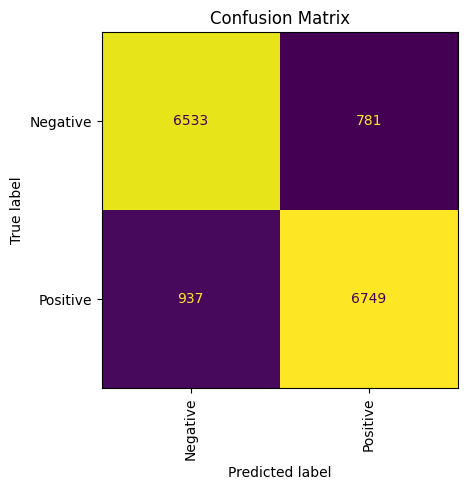

In [29]:
import mlflow
from sklearn.metrics import classification_report

# Подключение к серверу MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")
# Зафиксируем текущее название эксперимента
embeddings_experiment = mlflow.set_experiment("Embeddings_50k")

# Зафиксируем название текущего запуска, если не фиксировать, оно автосгенерируется
raw_bert_run_name = "raw_bert_embeddings"

with mlflow.start_run(run_name=raw_bert_run_name) as run:
    model_params = {
        "multi_class": "multinomial",
        "solver": "saga",
        "random_state": random_state,
    }
    model_lr = LogisticRegression(**model_params)
    model_lr.fit(train_embeddings, train["Polarity"])
    predicts = model_lr.predict(test_embeddings)
    report = classification_report(test["Polarity"], predicts, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=model_lr, 
        input_example=test_embeddings[:10].numpy(), 
        artifact_path=f"mlflow/{raw_bert_run_name}/model"
    )
    
     # Получение confusion matrix на два класса
    fig = conf_matrix(test["Polarity"], predicts)
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{raw_bert_run_name}_confusion_matrix.png')